# Topic Modeling - BERTopic

BERTopic is a topic modeling technique that leverages BERT embeddings to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. It utilizes transformer-based deep learning models to identify topics in large text collections.

The notebook follows the steps:
1. Preprocessing for BERTopic
2. Topic Modeling
3. Visualization

## 0. Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('stopwords')
import sys
sys.path.insert(0, '../../src/02 Data Preprocessing')
from Preprocessing_en import preprocess_data
from hdbscan import HDBSCAN
import pickle
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/whatsupaleks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Preprocessing for BERTopic

After loading the data file, we need to apply preprocessing steps to clean the original dataset. Therefore, we use the preprocessing function from our preprocessing python file. There you will find further explanation and data exploration. For the BERTopic modeling we use every step from our preprocessing pipeline including the stemmer. This is somewhat not ideal for the later visualization as can be seen below. However, we expect better performance due to the reduction of variability of words. 

We also have two different versions of the website texts after translating them (further explanation in the translation python file): english and german. First, we tried german since we have more texts in german. However, translating from english to german introduced a bigger translation loss than the other way around which is why we ended up using the english version.

In [3]:
# Read data as dataframe
df = pd.read_json("../../data/preprocessed/translated_results_en.json")
df.head()

,name,original_idx,website_url,website_text,original_language,website_text_in_en
0,itravel,0,https://www.itravel.de/,itravel Telefonische Beratung +49 221 8282 888...,de,itravel Telephone advice +49 221 8282 8880 | S...
1,kunveno,2,https://kunveno.de,Kunveno - Work Happier WORK HAPPIER Booste Unt...,de,Kunveno - Work Happier WORK HAPPIER Boost cult...
3,Scopas,4,https://www.scopas.io/,ScopasWe're working on something new.Check it ...,en,ScopasWe're working on something new.Check it ...
4,studymaniac,5,https://studymaniac.de,Studymaniac - erfolgreich Studieren Open main ...,de,Studymaniac - study successfully Open main men...
6,Aicone,9,http://www.ai-c.one,Aicone - Artificial Intelligence Cloud One | A...,en,Aicone - Artificial Intelligence Cloud One | A...


In [4]:
# Apply preprocessing on website text
df['website_text_in_en'] = preprocess_data(df['website_text_in_en'])
df.head()

,name,original_idx,website_url,website_text,original_language,website_text_in_en
0,itravel,0,https://www.itravel.de/,itravel Telefonische Beratung +49 221 8282 888...,de,itravel telephon advic switzerland arrang call...
1,kunveno,2,https://kunveno.de,Kunveno - Work Happier WORK HAPPIER Booste Unt...,de,kunveno work happier work happier boost cultur...
3,Scopas,4,https://www.scopas.io/,ScopasWe're working on something new.Check it ...,en,scopaswer work someth new check here
4,studymaniac,5,https://studymaniac.de,Studymaniac - erfolgreich Studieren Open main ...,de,studymaniac studi success open main menu partn...
6,Aicone,9,http://www.ai-c.one,Aicone - Artificial Intelligence Cloud One | A...,en,aicon artifici intellig cloud advanc analyt fu...


In [53]:
docs = df['website_text_in_en']

## 2. Topic Modeling

BERTopic can be viewed as a sequence of steps to create its topic representations. There are five steps to this process:

1. Embed documents:
Convert documents to numerical representations using sentence-transformers models optimized for semantic similarity. BERTopic provides default models like "all-MiniLM-L6-v2" and "paraphrase-multilingual-MiniLM-L12-v2".
2. Dimensionality reduction:
Reduce the dimensionality of document representations using UMAP (default in BERTopic). UMAP preserves local and global structure, aiding in creating clusters of semantically similar documents.
3. Cluster Documents:
Apply HDBSCAN, a density-based clustering technique, to cluster the reduced embeddings. HDBSCAN identifies clusters of varying shapes and detects outliers effectively.
4. Bag-of-words:
Create a bag-of-words representation on a cluster level, combining documents within each cluster. Count the frequency of words within each cluster, allowing for a modular approach that makes no assumptions about cluster structure.
5. Topic representation:
Modify TF-IDF to consider topics (clusters) instead of individual documents. Convert each cluster to a single document and calculate the importance scores of words within clusters. Class-based TF-IDF is used, where importance scores reflect word relevance to specific topics.
6. (Optional) Fine-tune Topic representation:
After generating c-TF-IDF representations, further fine-tune topics using techniques like GPT, T5, KeyBERT, Spacy, etc. Use the representative documents and keywords from c-TF-IDF as candidate topics for fine-tuning. Fine-tuning reduces computation by operating on a small set of representative documents per topic.

In [46]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [48]:
# Fit the model
topic_model.fit_transform(docs)

([-1,
  1,
  8,
  11,
  16,
  -1,
  2,
  9,
  7,
  0,
  -1,
  -1,
  10,
  -1,
  4,
  -1,
  0,
  -1,
  -1,
  -1,
  24,
  11,
  12,
  -1,
  -1,
  3,
  20,
  -1,
  -1,
  -1,
  -1,
  -1,
  0,
  -1,
  -1,
  -1,
  -1,
  14,
  1,
  11,
  4,
  -1,
  17,
  7,
  12,
  -1,
  10,
  -1,
  10,
  1,
  -1,
  0,
  -1,
  -1,
  0,
  -1,
  -1,
  -1,
  -1,
  2,
  -1,
  -1,
  0,
  4,
  -1,
  -1,
  5,
  -1,
  23,
  -1,
  -1,
  27,
  -1,
  10,
  -1,
  6,
  -1,
  29,
  6,
  -1,
  26,
  8,
  14,
  1,
  -1,
  -1,
  -1,
  0,
  32,
  0,
  -1,
  -1,
  -1,
  33,
  -1,
  1,
  17,
  1,
  -1,
  -1,
  6,
  -1,
  32,
  18,
  -1,
  25,
  4,
  19,
  1,
  -1,
  2,
  18,
  15,
  -1,
  -1,
  -1,
  0,
  6,
  0,
  -1,
  -1,
  0,
  16,
  12,
  -1,
  23,
  18,
  -1,
  -1,
  0,
  -1,
  19,
  -1,
  16,
  6,
  -1,
  -1,
  -1,
  -1,
  2,
  1,
  -1,
  0,
  -1,
  4,
  9,
  8,
  -1,
  11,
  1,
  -1,
  5,
  14,
  -1,
  16,
  25,
  -1,
  11,
  9,
  18,
  0,
  7,
  15,
  -1,
  -1,
  0,
  19,
  2,
  14,
  -1,
  22,
  -1,
  -1,
  13,
  15,
 

In [55]:
# Save the model so you can load it instead of retraining it
pickle.dump(topic_model,open("../../models/bert_topic_model.pkl","wb"))

In [49]:
# Show topics with word representation. -1 refers to all outliers and should typically be ignored. 
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1402,-1_industri_employe_servic_easi,"[industri, employe, servic, easi, data, design...",[deliv digit product cto servic rocketloop cto...
1,0,279,0_health_medic_medicin_servic,"[health, medic, medicin, servic, healthcar, cl...",[temedica personalis health need real insight ...
2,1,116,1_recruit_hire_employe_career,"[recruit, hire, employe, career, employ, appre...",[kalaydo de job exchang vacanc find good job e...
3,2,83,2_photovolta_solar_pv_industri,"[photovolta, solar, pv, industri, energi, grid...",[clean energi global batteri servic iot modul ...
4,3,80,3_shop_retail_cart_sneaker,"[shop, retail, cart, sneaker, fashion, brand, ...",[buy lamp light onlin buyer protect free ship ...
5,4,72,4_hotel_holiday_rental_rent,"[hotel, holiday, rental, rent, travel, trip, v...",[rent cheap holiday apart holiday hous hometog...
6,5,70,5_invest_portfolio_investor_financ,"[invest, portfolio, investor, financ, market, ...",[digit asset manag bevestorpleas turn smartpho...
7,6,60,6_industri_manufactur_design_develop,"[industri, manufactur, design, develop, autom,...",[iconpro ai manufactur lead industri solut let...
8,7,59,7_marketplac_market_retail_shop,"[marketplac, market, retail, shop, salesforc, ...",[power dtc marketplac revolut tradebyt hi saa ...
9,8,56,8_blog_openem_brand_gmbh,"[blog, openem, brand, gmbh, industri, stori, s...",[cutnut stori made simpl stori made simpl scro...


## 3. Visualization

In order to interpret the clusters and identify industry branches, we need to visualize the topics for each cluster. We use visualization techniques such as the Wordcloud package to do so.

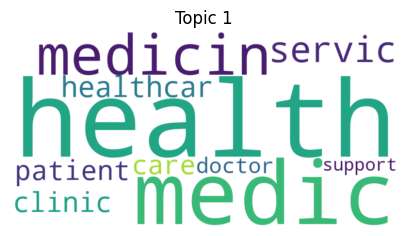

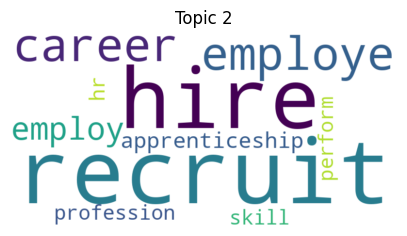

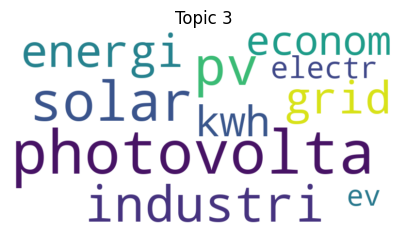

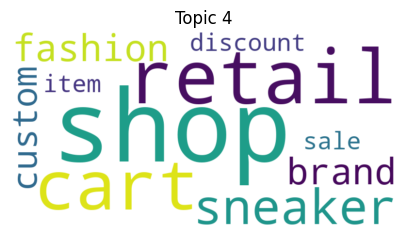

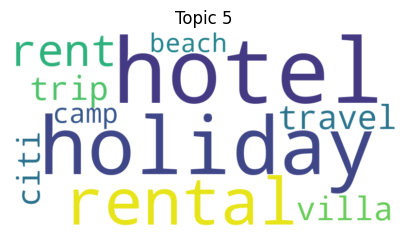

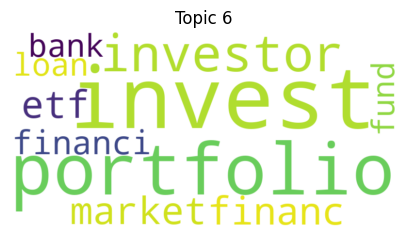

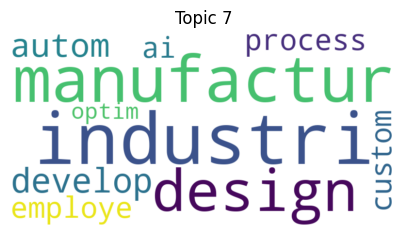

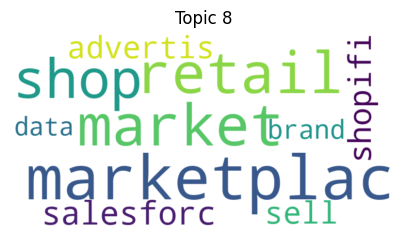

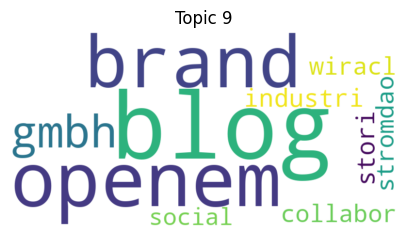

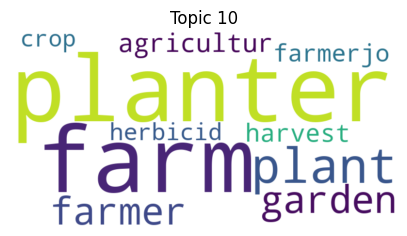

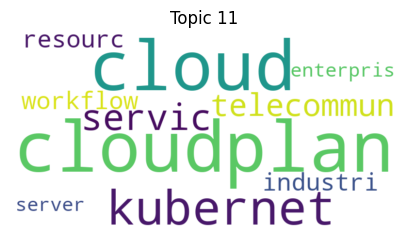

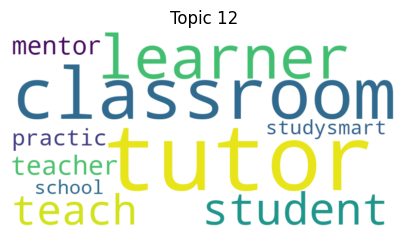

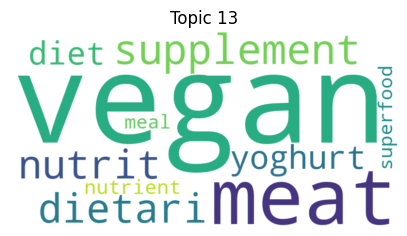

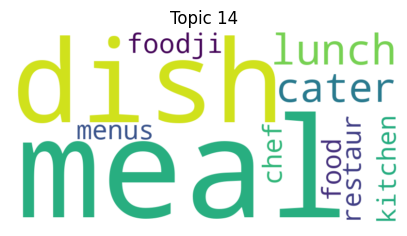

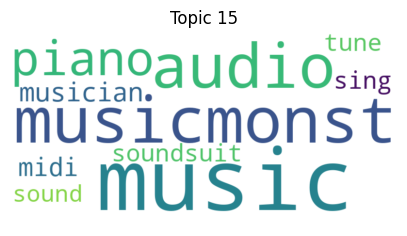

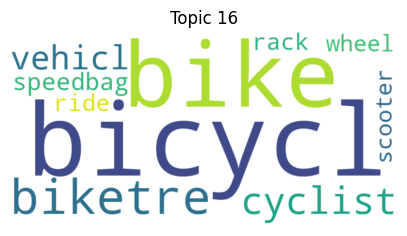

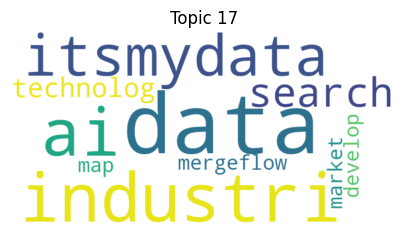

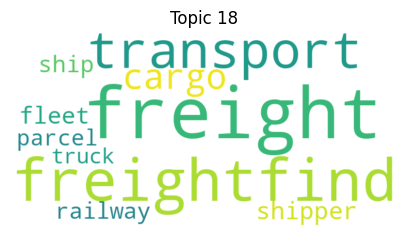

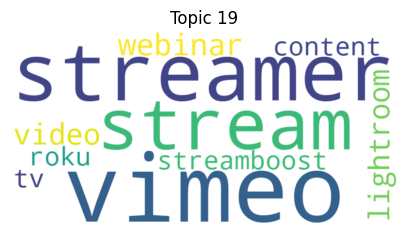

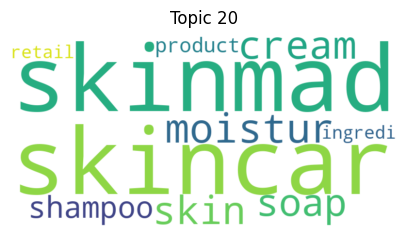

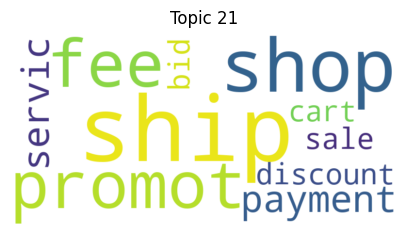

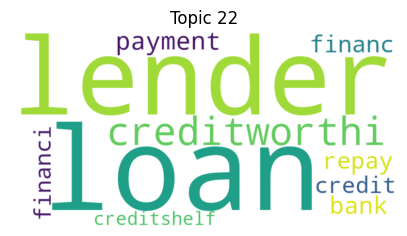

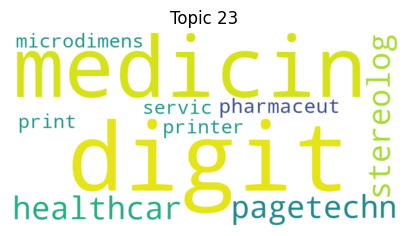

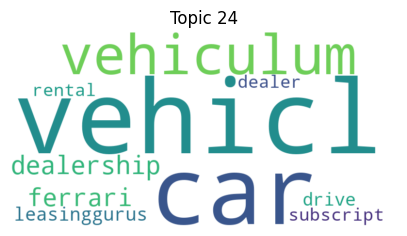

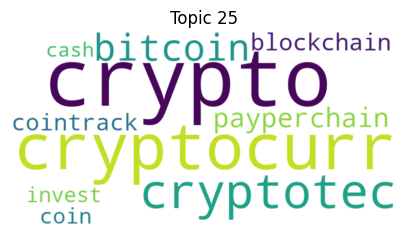

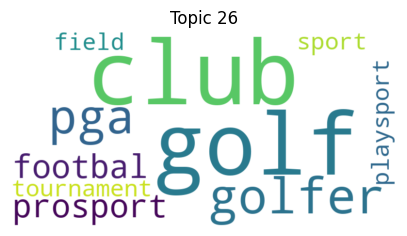

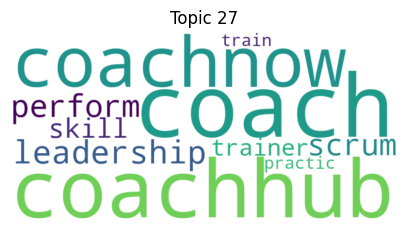

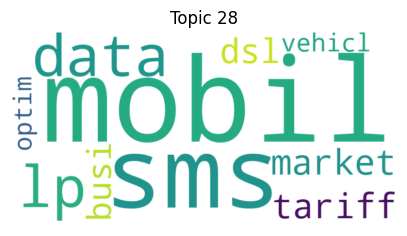

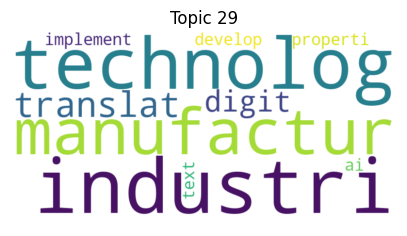

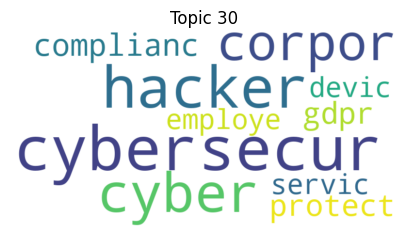

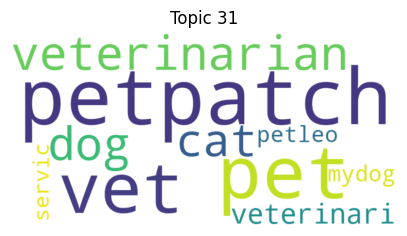

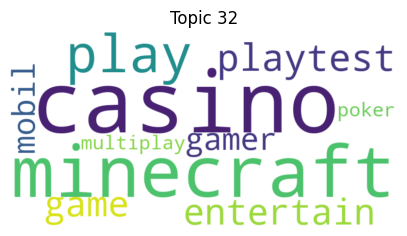

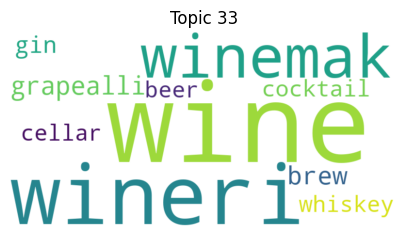

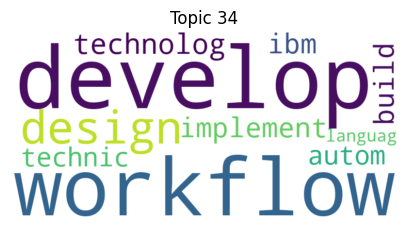

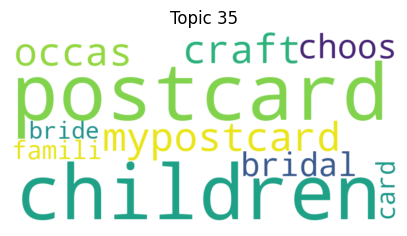

In [50]:
topics = topic_model.get_topics()
for topic_id in range(len(topics) -1):
    topic_words = dict(topics[topic_id])
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(topic_words)

    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id +1}')
    plt.show()

Looking at the intertopic distance map, we can see that the clusters have a lot of overlap. If we look closer at the clusters we can see that thematically and semantically they are very similar for example one cluster that is about food in general while another overlapping one is specifically about vegan food (topic 12 and 13). 

In [51]:
topic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'health | medic | medicin | servic | healthcar', 279],
                                   [1, 'recruit | hire | employe | career | employ', 116],
                                   [2, 'photovolta | solar | pv | industri | energi', 83],
                                   [3, 'shop | retail | cart | sneaker | fashion', 80],
                                   [4, 'hotel | holiday | rental | rent | travel', 72],
                                   [5, 'invest | portfolio | investor | financ | market', 70],
                                   [6, 'industri | manufactur | design | develop | autom', 60],
                                   [7, 'marketplac | market | retail | shop | salesforc', 59],
                                   [8, 'blog | openem | brand | gmbh | industri', 56],
                                   [9, 'planter | farm | plant | garden | farmer', 49],
                                   [10, 'cloudplan | cloud | kubernet | servic | telecommun', 49],
                                   [11, 'tutor | classroom | learner | student | teach', 45],
                                   [12, 'vegan | meat | supplement | dietari | nutrit', 41],
                                   [13, 'meal | dish | lunch | cater | foodji', 38],
                                   [14, 'music | musicmonst | audio | piano | musician', 36],
                                   [15, 'bicycl | bike | biketre | cyclist | vehicl', 36],
                                   [16, 'data | industri | ai | itsmydata | search', 35],
                                   [17, 'freight | freightfind | transport | cargo | shipper', 33],
                                   [18, 'vimeo | streamer | stream | webinar | video', 33],
                                   [19, 'skinmad | skincar | moistur | cream | skin', 30],
                                   [20, 'ship | shop | promot | fee | payment', 29],
                                   [21, 'loan | lender | creditworthi | payment | bank', 29],
                                   [22, 'digit | medicin | healthcar | pagetechn | stereolog', 26],
                                   [23, 'vehicl | car | vehiculum | dealership | ferrari', 26],
                                   [24, 'crypto | cryptocurr | cryptotec | bitcoin | payperchain', 24],
                                   [25, 'club | golf | golfer | pga | prosport', 20],
                                   [26, 'coach | coachhub | coachnow | leadership | perform', 20],
                                   [27, 'mobil | sms | data | lp | market', 20],
                                   [28, 'industri | technolog | manufactur | translat | digit', 20],
                                   [29, 'cybersecur | hacker | cyber | corpor | complianc', 19],
                                   [30, 'petpatch | pet | vet | veterinarian | dog', 19],
                                   [31, 'casino | minecraft | play | playtest | entertain', 19],
                                   [32, 'wine | wineri | winemak | grapealli | brew', 18],
                                   [33, 'develop | workflow | design | technolog | implement', 15],
                                   [34, 'postcard | children | mypostcard | craft | occas', 15]],
                                  dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([279, 116,  83,  80,  72,  70,  60,  59,  56,  49,  49,  45,  41,  38,
                                         36,  36,  35,  33,  33,  30,  29,  29,  26,  26,  24,  20,  20,  20,
                                         20,  19,  19,  19,  18,  15,  15]),
                         'sizemode': 'area',
                         'sizeref': 0.174375,
                         'symbol

This cluster overlap can be further shown by plotting the similarity matrix which shows how similar the topics are. If we look at topic 12 and 13 again, we see that they have a very similar score.

In [52]:
topic_model.visualize_heatmap()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_health_medic_medicin, 1_recruit_hire_employe,
                    2_photovolta_solar_pv, 3_shop_retail_cart,
                    4_hotel_holiday_rental, 5_invest_portfolio_investor,
                    6_industri_manufactur_design, 7_marketplac_market_retail,
                    8_blog_openem_brand, 9_planter_farm_plant,
                    10_cloudplan_cloud_kubernet, 11_tutor_classroom_learner,
                    12_vegan_meat_supplement, 13_meal_dish_lunch,
                    14_music_musicmonst_audio, 15_bicycl_bike_biketre,
                    16_data_industri_ai, 17_freight_freightfind_tran...,
                    18_vimeo_streamer_stream, 19_skinmad_skincar_moistur,
                    20_ship_shop_promot, 21_loan_lender_creditworthi,
                    22_digit_medicin_healthcar, 23_vehicl_car_vehiculum,
                    24_crypto_cryptocurr_crypto..., 25_club_golf_golfer,
                    26_coach_coachhub_coachnow, 27_mobil_sms_data,
                    28_industri_technolog_manuf..., 29_cybersecur_hacker_cyber,
                    30_petpatch_pet_vet, 31_casino_minecraft_play,
                    32_wine_wineri_winemak, 33_develop_workflow_design,
                    34_postcard_children_mypost...],
              'xaxis': 'x',
              'y': [0_health_medic_medicin, 1_recruit_hire_employe,
                    2_photovolta_solar_pv, 3_shop_retail_cart,
                    4_hotel_holiday_rental, 5_invest_portfolio_investor,
                    6_industri_manufactur_design, 7_marketplac_market_retail,
                    8_blog_openem_brand, 9_planter_farm_plant,
                    10_cloudplan_cloud_kubernet, 11_tutor_classroom_learner,
                    12_vegan_meat_supplement, 13_meal_dish_lunch,
                    14_music_musicmonst_audio, 15_bicycl_bike_biketre,
                    16_data_industri_ai, 17_freight_freightfind_tran...,
                    18_vimeo_streamer_stream, 19_skinmad_skincar_moistur,
                    20_ship_shop_promot, 21_loan_lender_creditworthi,
                    22_digit_medicin_healthcar, 23_vehicl_car_vehiculum,
                    24_crypto_cryptocurr_crypto..., 25_club_golf_golfer,
                    26_coach_coachhub_coachnow, 27_mobil_sms_data,
                    28_industri_technolog_manuf..., 29_cybersecur_hacker_cyber,
                    30_petpatch_pet_vet, 31_casino_minecraft_play,
                    32_wine_wineri_winemak, 33_develop_workflow_design,
                    34_postcard_children_mypost...],
              'yaxis': 'y',
              'z': array([[0.9999999 , 0.78091717, 0.6865967 , ..., 0.52834666, 0.75496775,
                           0.5800761 ],
                          [0.78091717, 1.0000001 , 0.7071806 , ..., 0.5557276 , 0.8420707 ,
                           0.57110417],
                          [0.6865967 , 0.7071806 , 0.99999964, ..., 0.5607197 , 0.80867004,
                           0.5278462 ],
                          ...,
                          [0.52834666, 0.5557276 , 0.5607197 , ..., 1.        , 0.5361155 ,
                           0.59997284],
                          [0.75496775, 0.8420707 , 0.80867004, ..., 0.5361155 , 1.        ,
                           0.5543431 ],
                          [0.5800761 , 0.57110417, 0.5278462 , ..., 0.59997284, 0.5543431 ,
                           1.        ]], dtype=float32)}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,


These overlaps could be a potential for merging certain clusters into bigger ones. To see clearer which topic clusters could be merged into bigger ones, we can plot the dendrogram of the hierarchical clustering.

In [54]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 34/34 [00:39<00:00,  1.16s/it]


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [skinmad_skincar_moistur_cream_skin, , ,
                       shop_retail_cart_sneaker_fashion],
              'type': 'scatter',
              'x': array([0.        , 0.60165968, 0.60165968, 0.        ]),
              'xaxis': 'x',
              'y': array([-25., -25., -35., -35.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [shop_retail_brand_fashion_product, , ,
                       postcard_children_mypostcard_craft_occas],
              'type': 'scatter',
              'x': array([0.60165968, 0.726191  , 0.726191  , 0.        ]),
              'xaxis': 'x',
              'y': array([-30., -30., -45., -45.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [ship_shop_promot_fee_payment, , ,
                       shop_retail_brand_fashion_product],
              'type': 'scatter',
              'x': array([0.        , 0.76917451, 0.76917451, 0.726191  ]),
              'xaxis': 'x',
              'y': array([-15. , -15. , -37.5, -37.5]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [shop_retail_brand_fashion_product, , ,
                       petpatch_pet_vet_veterinarian_dog],
              'type': 'scatter',
              'x': array([0.76917451, 0.81601832, 0.81601832, 0.        ]),
              'xaxis': 'x',
              'y': array([-26.25, -26.25, -55.  , -55.  ]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [wine_wineri_winemak_grapealli_brew, , ,
                       brand_retail_fashion_shop_categori],
              'type': 'scatter',
              'x': array([0.        , 0.85655863, 0.85655863, 0.81601832]),
              'xaxis': 'x',
              'y': array([ -5.   ,  -5.   , -40.625, -40.625]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [vegan_meat_supplement_dietari_nutrit, , ,
                       planter_farm_plant_garden_farmer],
              'type': 'scatter',
              'x': array([0.        , 0.55496172, 0.55496172, 0.        ]),
              'xaxis': 'x',
              'y': array([-75., -75., -85., -85.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [meal_dish_lunch_cater_foodji, , ,
                       planter_vegan_plant_qualiti_grass],
              'type': 'scatter',
              'x': array([0.        , 0.68155289, 0.68155289, 0.55496172]),
              'xaxis': 'x',
              'y': array([-65., -65., -80., -80.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'text': [brand_retail_categori_servic_shop, , ,
                       dish_planter_qualiti_healthi_cater],
              'type': 'scatter',
              'x': array([0.85655863, 0.90509647, 0.90509647, 0.68155289]),
              'xaxis': 'x',
              'y': array([-22.8125, -22.8125, -72.5   , -72.5   ]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'text': [photovolta_solar_pv_industri_energi, , ,
                       mobil_sms_data_lp_market],
              'type': 'scatter',
           

After generating topics and their probabilities, we can access the frequent topics that were generated:

In [43]:
topic_model.visualize_barchart(top_n_topics=29)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.015574131171787178, 0.02288132794417885,
                    0.02306366313460161, 0.023250699489070898, 0.03257478121111547],
              'xaxis': 'x',
              'y': [doctor  , health  , medic  , care  , patient  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.020518868577973855, 0.021125460968140213,
                    0.02456165090181291, 0.02552764115184366, 0.027623600099971928],
              'xaxis': 'x2',
              'y': [tast  , vegan  , organ  , sprout  , food  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.021244997368822464, 0.021569636364477045,
                    0.02381313818262364, 0.03218348637882738, 0.04410173991685771],
              'xaxis': 'x3',
              'y': [compani  , talent  , hr  , employe  , job  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.015976695047217028, 0.017594726592373364,
                    0.018470463303238125, 0.023027624776006644,
                    0.05772993484772279],
              'xaxis': 'x4',
              'y': [product  , design  , light  , shop  , eur  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03649933881038765, 0.037073779355917255,
                    0.040271255042168275, 0.04323537457560667, 0.05814174136076113],
              'xaxis': 'x5',
              'y': [batteri  , solar  , system  , electr  , energi  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02723600012151573, 0.027915356375801427,
                    0.03289848021620902, 0.043189204684264106, 0.06037095694788545],
              'xaxis': 'x6',
              'y': [player  , sport  , club  , coach  , game  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.020051476500437374, 0.024985079712151605,
                    0.043581350549398074, 0.045498376385101603,
                    0.04691223303741702],
              'xaxis': 'x7',
              'y': [process  , robot  , array  , imag  , contao  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.029331316878387352, 0.029808412565473685,
                    0.04137756338743656, 0.050866262295178585, 0.05256411309772526],
              'xaxis': 'x8',
              'y': [trip  , rent  , travel  , holiday  , hotel  ],
              'yaxis': 'y8'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.027226103983936246, 0.02854927495113767,
                    0.035603211769873765, 0.03894930580506885, 0.07671047839761258],
              'xaxis': 'x9',
              'y': [save  , bank  , asset  , etf  , invest  ],
              'yaxis': 'y9'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.029051980034864318, 0.029051980034864318,
                    0.03284638793102007, 0.03439369493126479, 0.03861458959504695],
              'xaxis': 'x10',
              'y': [tellma  , stromdao  , stori  , blog  , gmbh  ],
              'yaxis': 'y10'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
        

In [41]:
topic_model.visualize_term_rank()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertext': '<b>Topic -1</b>:custom_data_use_product_time_manag',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.01375634, 0.01285085, 0.01188759, 0.01144021, 0.0112698 , 0.01069819,
                          0.01046174, 0.01034378, 0.01000534, 0.00984395])},
             {'hovertext': '<b>Topic 0</b>:patient_care_medic_health_doctor_cl',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.03257478, 0.0232507 , 0.02306366, 0.02288133, 0.01557413, 0.01503981,
                          0.01435921, 0.01354292, 0.01188159, 0.01107417])},
             {'hovertext': '<b>Topic 1</b>:food_sprout_organ_vegan_tast_delici',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.0276236 , 0.02552764, 0.02456165, 0.02112546, 0.02051887, 0.01982104,
                          0.01800853, 0.0177502 , 0.01583633, 0.01524227])},
             {'hovertext': '<b>Topic 2</b>:job_employe_hr_talent_compani_appli',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.04410174, 0.03218349, 0.02381314, 0.02156964, 0.021245  , 0.02038966,
                          0.01884724, 0.01861964, 0.01832945, 0.01830968])},
             {'hovertext': '<b>Topic 3</b>:eur_shop_light_design_product_fashi',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.05772993, 0.02302762, 0.01847046, 0.01759473, 0.0159767 , 0.01582507,
                          0.01498254, 0.0148317 , 0.01480026, 0.01422066])},
             {'hovertext': '<b>Topic 4</b>:energi_electr_system_solar_batteri_',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.05814174, 0.04323537, 0.04027126, 0.03707378, 0.03649934, 0.02889962,
                          0.0258316 , 0.02437149, 0.02316999, 0.01779716])},
             {'hovertext': '<b>Topic 5</b>:game_coach_club_sport_player_train_',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.06037096, 0.0431892 , 0.03289848, 0.02791536, 0.027236  , 0.02694648,
                          0.0247003 , 0.02211563, 0.01739587, 0.01686892])},
             {'hovertext': '<b>Topic 6</b>:contao_imag_array_robot_process_cod',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.04691223, 0.04549838, 0.04358135, 0.02498508, 0.02005148, 0.01947609,
                    

Using `get_document_info`, we can also extract information on a document level, such as their corresponding topics, probabilities, whether they are representative documents for a topic, etc.:

In [42]:
topic_model.get_document_info(df['website_text_in_en'])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,itravel telephon advic switzerland arrang call...,-1,-1_custom_data_use_product,"[custom, data, use, product, time, manag, serv...",[jostec system jostec system jostec system amo...,custom - data - use - product - time - manag -...,0.000000,False
1,kunveno work happier work happier boost cultur...,2,2_job_employe_hr_talent,"[job, employe, hr, talent, compani, applic, re...",[kalaydo de job exchang vacanc find good job e...,job - employe - hr - talent - compani - applic...,0.521990,False
2,scopaswer work someth new check here,9,9_gmbh_blog_stori_stromdao,"[gmbh, blog, stori, stromdao, tellma, page, co...",[eyeo ad filter meet profit top contact homepa...,gmbh - blog - stori - stromdao - tellma - page...,1.000000,False
3,studymaniac studi success open main menu partn...,15,15_school_learn_tutor_student,"[school, learn, tutor, student, teacher, lesso...",[onlin tutor lead tutor provid onlin tutor top...,school - learn - tutor - student - teacher - l...,1.000000,False
4,aicon artifici intellig cloud advanc analyt fu...,11,11_data_protect_secur_busi,"[data, protect, secur, busi, use, manag, compa...",[datarad find right data effortless popular ca...,data - protect - secur - busi - use - manag - ...,0.679339,False
...,...,...,...,...,...,...,...,...
3016,coleap transform content incometurn content in...,-1,-1_custom_data_use_product,"[custom, data, use, product, time, manag, serv...",[jostec system jostec system jostec system amo...,custom - data - use - product - time - manag -...,0.000000,False
3017,use industri equip onlin trademachinesenglishu...,10,10_sale_custom_commerc_price,"[sale, custom, commerc, price, product, market...",[human experi platform e commerc compani selec...,sale - custom - commerc - price - product - ma...,0.788605,False
3018,home yasoon patrick partner manag get touch mi...,-1,-1_custom_data_use_product,"[custom, data, use, product, time, manag, serv...",[jostec system jostec system jostec system amo...,custom - data - use - product - time - manag -...,0.000000,False
3019,phoneboost boost phone batteri emptyphoneboost...,4,4_energi_electr_system_solar,"[energi, electr, system, solar, batteri, charg...",[tenant electr altern solar small multi famili...,energi - electr - system - solar - batteri - c...,1.000000,False
